In [2]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize feature extractor and ViT model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
num_classes = 3  # Update this based on your dataset
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
).to(device)

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dir = "c:/users/butech/Downloads/image_dataset_3labeled/train"
val_dir = "c:/users/butech/Downloads/image_dataset_3labeled/validation"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes

# Define optimizer, loss, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Checkpoint path
checkpoint_path = "c:/users/butech/Downloads/vit_best_model.pth"

# Training function with checkpoint saving
def train_model_with_checkpoints(model, train_loader, val_loader, epochs):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        scheduler.step(val_losses[-1])

        # Save checkpoint if this is the best model so far
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss:.4f}")

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses, y_true, y_pred

# Train the model
epochs = 10
train_losses, val_losses, y_true, y_pred = train_model_with_checkpoints(model, train_loader, val_loader, epochs)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Load the best model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_true_onehot = np.eye(len(class_names))[y_true]  # One-hot encode true labels
y_pred_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = torch.softmax(model(images).logits, dim=1)
        y_pred_probs.append(outputs.cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs, axis=0)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC: {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


c:\Users\butech\anaconda3\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\butech\anaconda3\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue:

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

c:\Users\butech\anaconda3\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model saved at epoch 1 with validation loss: 0.9046
Epoch 1/70, Training Loss: 0.9955, Validation Loss: 0.9046
Best model saved at epoch 2 with validation loss: 0.8059
Epoch 2/70, Training Loss: 0.8560, Validation Loss: 0.8059
Best model saved at epoch 3 with validation loss: 0.7492
Epoch 3/70, Training Loss: 0.7817, Validation Loss: 0.7492
Best model saved at epoch 4 with validation loss: 0.7125
Epoch 4/70, Training Loss: 0.7359, Validation Loss: 0.7125
Best model saved at epoch 5 with validation loss: 0.6874
Epoch 5/70, Training Loss: 0.7054, Validation Loss: 0.6874
Best model saved at epoch 6 with validation loss: 0.6690
Epoch 6/70, Training Loss: 0.6828, Validation Loss: 0.6690
Best model saved at epoch 7 with validation loss: 0.6541
Epoch 7/70, Training Loss: 0.6652, Validation Loss: 0.6541
Best model saved at epoch 8 with validation loss: 0.6424
Epoch 8/70, Training Loss: 0.6523, Validation Loss: 0.6424
Best model saved at epoch 9 with validation loss: 0.6329
Epoch 9/70, Tra

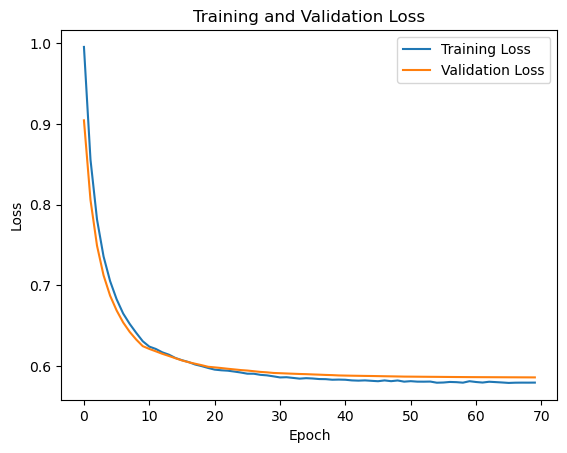

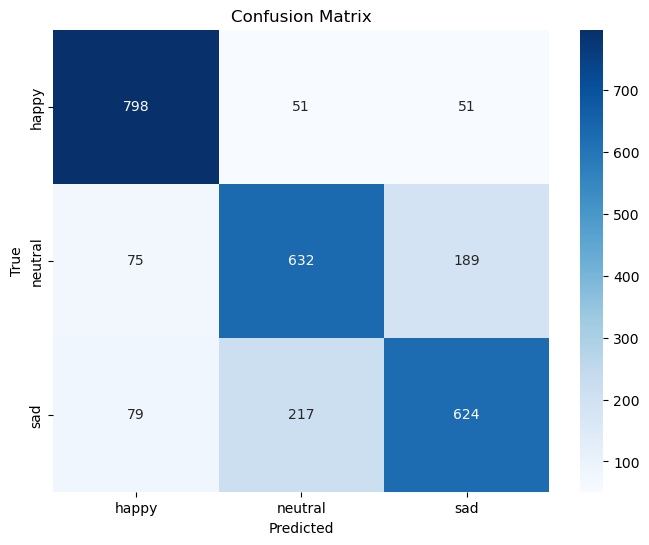

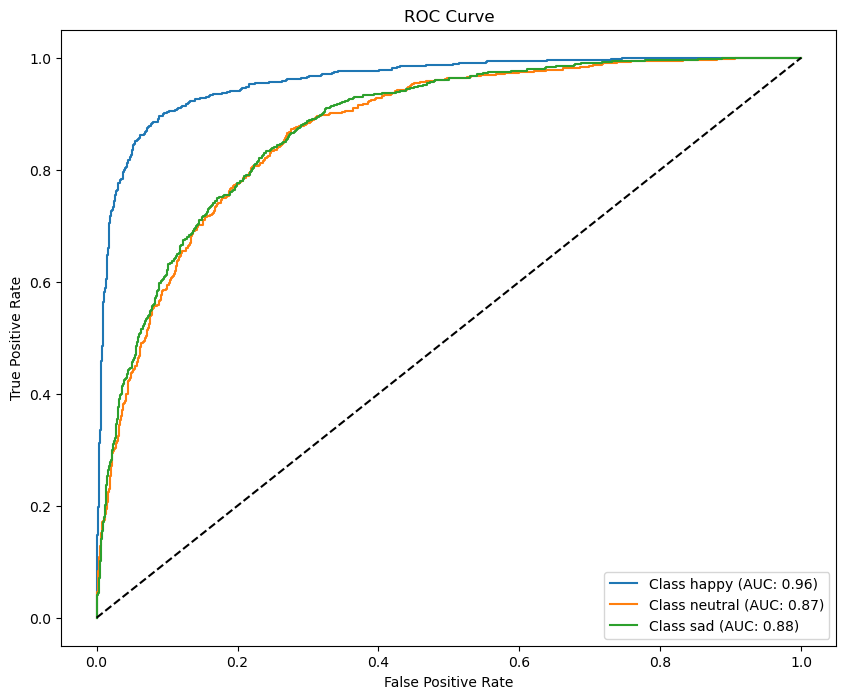

In [3]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize feature extractor and ViT model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
num_classes = 3  # Update this based on your dataset
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
).to(device)

# Freeze the base model (optional; use if initial training is unstable)
for param in model.vit.parameters():
    param.requires_grad = False

# Define preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dir = "c:/users/butech/Downloads/image_dataset_3labeled/train"
val_dir = "c:/users/butech/Downloads/image_dataset_3labeled/validation"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes

# Define optimizer, loss, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Checkpoint path
checkpoint_path = "c:/users/butech/Downloads/vit_best_model_finetuned.pth"

# Fine-tune the model
def fine_tune_model(model, train_loader, val_loader, epochs):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(torch.argmax(outputs, axis=1).cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        scheduler.step()

        # Save checkpoint if this is the best model so far
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss:.4f}")

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses, y_true, y_pred

# Train the fine-tuned model for 70 epochs
epochs = 70
train_losses, val_losses, y_true, y_pred = fine_tune_model(model, train_loader, val_loader, epochs)

# Plot training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Load the best model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_true_onehot = np.eye(len(class_names))[y_true]  # One-hot encode true labels
y_pred_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = torch.softmax(model(images).logits, dim=1)
        y_pred_probs.append(outputs.cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs, axis=0)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC: {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [5]:
from sklearn.metrics import accuracy_score
import numpy as np

# Accuracy function
def calculate_accuracy(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class indices
    return accuracy_score(y_true, y_pred_classes)

# Evaluate accuracy on the dataset
def evaluate_accuracy(data_loader, model, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Get predictions
            logits = outputs.logits  # Extract logits
            all_preds.extend(logits.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    accuracy = calculate_accuracy(np.array(all_labels), np.array(all_preds))
    return accuracy

# Calculate training accuracy
train_accuracy = evaluate_accuracy(train_loader, model, device)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Calculate validation accuracy
val_accuracy = evaluate_accuracy(val_loader, model, device)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


Training Accuracy: 75.66%
Validation Accuracy: 75.63%


c:\Users\butech\anaconda3\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model saved at epoch 1 with validation loss: 0.8274
Epoch 1/70, Train Loss: 0.9289, Train Accuracy: 64.68%, Val Loss: 0.8274, Val Accuracy: 69.96%
Best model saved at epoch 2 with validation loss: 0.7683
Epoch 2/70, Train Loss: 0.8032, Train Accuracy: 70.27%, Val Loss: 0.7683, Val Accuracy: 71.87%
Best model saved at epoch 3 with validation loss: 0.7461
Epoch 3/70, Train Loss: 0.7692, Train Accuracy: 71.43%, Val Loss: 0.7461, Val Accuracy: 72.90%
Best model saved at epoch 4 with validation loss: 0.7380
Epoch 4/70, Train Loss: 0.7554, Train Accuracy: 71.97%, Val Loss: 0.7380, Val Accuracy: 74.01%
Best model saved at epoch 5 with validation loss: 0.7315
Epoch 5/70, Train Loss: 0.7459, Train Accuracy: 72.82%, Val Loss: 0.7315, Val Accuracy: 74.56%
Best model saved at epoch 6 with validation loss: 0.7302
Epoch 6/70, Train Loss: 0.7404, Train Accuracy: 72.72%, Val Loss: 0.7302, Val Accuracy: 73.82%
Best model saved at epoch 7 with validation loss: 0.7189
Epoch 7/70, Train Loss: 0.7366,

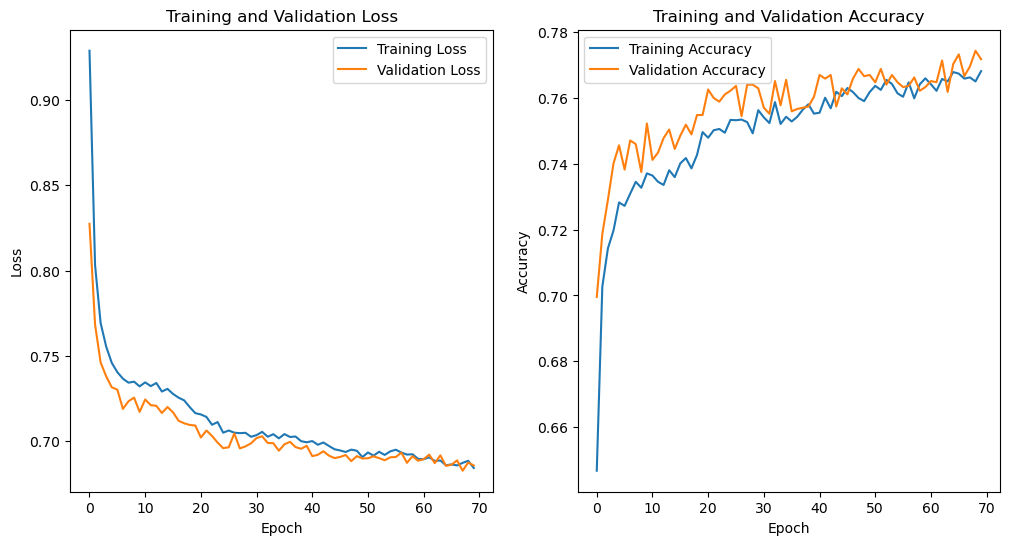

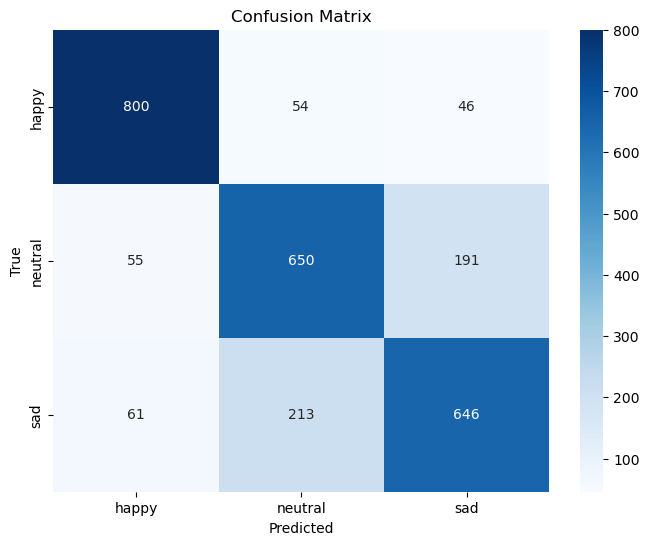

              precision    recall  f1-score   support

       happy       0.87      0.89      0.88       900
     neutral       0.71      0.73      0.72       896
         sad       0.73      0.70      0.72       920

    accuracy                           0.77      2716
   macro avg       0.77      0.77      0.77      2716
weighted avg       0.77      0.77      0.77      2716



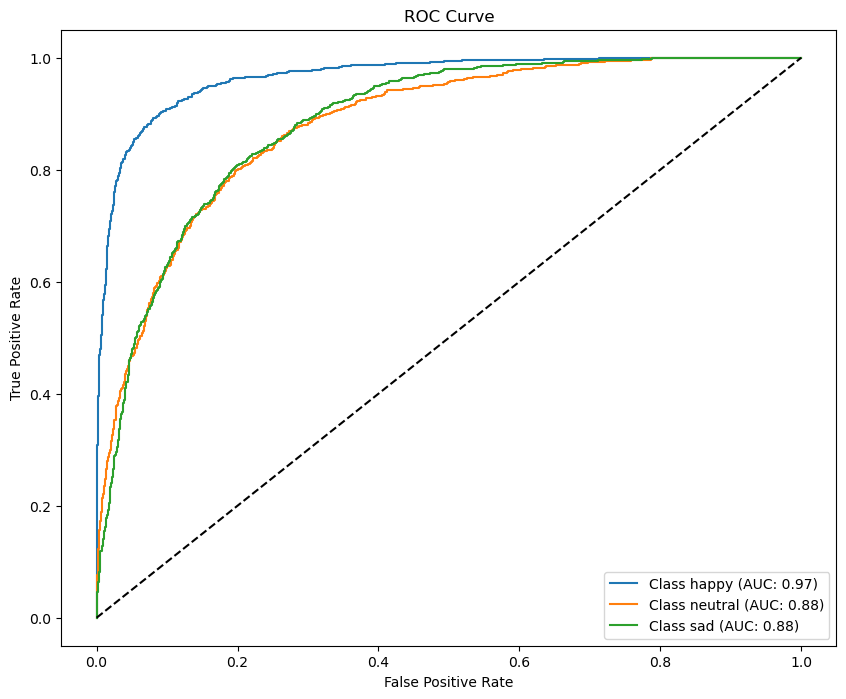

In [6]:
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize feature extractor and ViT model
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
num_classes = 3  # Update this based on your dataset
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
).to(device)

# Freeze the base model (optional)
for param in model.vit.parameters():
    param.requires_grad = False

# Define preprocessing with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dir = "c:/users/butech/Downloads/image_dataset_3labeled/train"
val_dir = "c:/users/butech/Downloads/image_dataset_3labeled/validation"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes

# Calculate class weights for CrossEntropyLoss
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], device=device)

# Define loss with label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Checkpoint path
checkpoint_path = "c:/users/butech/Downloads/vit_best_model_refinetuned.pth"

# Fine-tune the model
def fine_tune_model(model, train_loader, val_loader, epochs):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Accuracy calculation
            preds = torch.argmax(outputs, axis=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        val_loss = 0
        correct_val, total_val = 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, axis=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        scheduler.step()

        # Save checkpoint if this is the best model so far
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss:.4f}")

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1] * 100:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1] * 100:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred

# Train the fine-tuned model for 70 epochs
epochs = 70
train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred = fine_tune_model(model, train_loader, val_loader, epochs)

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Load the best model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# ROC Curve
y_true_onehot = np.eye(len(class_names))[y_true]  # One-hot encode true labels
y_pred_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = torch.softmax(model(images).logits, dim=1)
        y_pred_probs.append(outputs.cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs, axis=0)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC: {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-base-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best model saved at epoch 1 with validation loss: 0.7604
Epoch 1/50, Train Loss: 0.8785, Train Accuracy: 63.89%, Val Loss: 0.7604, Val Accuracy: 71.72%
Best model saved at epoch 2 with validation loss: 0.7313
Epoch 2/50, Train Loss: 0.7630, Train Accuracy: 71.32%, Val Loss: 0.7313, Val Accuracy: 73.78%
Best model saved at epoch 3 with validation loss: 0.7151
Epoch 3/50, Train Loss: 0.7432, Train Accuracy: 73.02%, Val Loss: 0.7151, Val Accuracy: 74.89%
Best model saved at epoch 4 with validation loss: 0.7120
Epoch 4/50, Train Loss: 0.7347, Train Accuracy: 73.38%, Val Loss: 0.7120, Val Accuracy: 75.29%
Best model saved at epoch 5 with validation loss: 0.7103
Epoch 5/50, Train Loss: 0.7266, Train Accuracy: 73.70%, Val Loss: 0.7103, Val Accuracy: 75.81%
Best model saved at epoch 6 with validation loss: 0.7056
Epoch 6/50, Train Loss: 0.7251, Train Accuracy: 73.94%, Val Loss: 0.7056, Val Accuracy: 75.63%
Best model saved at epoch 7 with validation loss: 0.7023
Epoch 7/50, Train Loss: 0.7207,

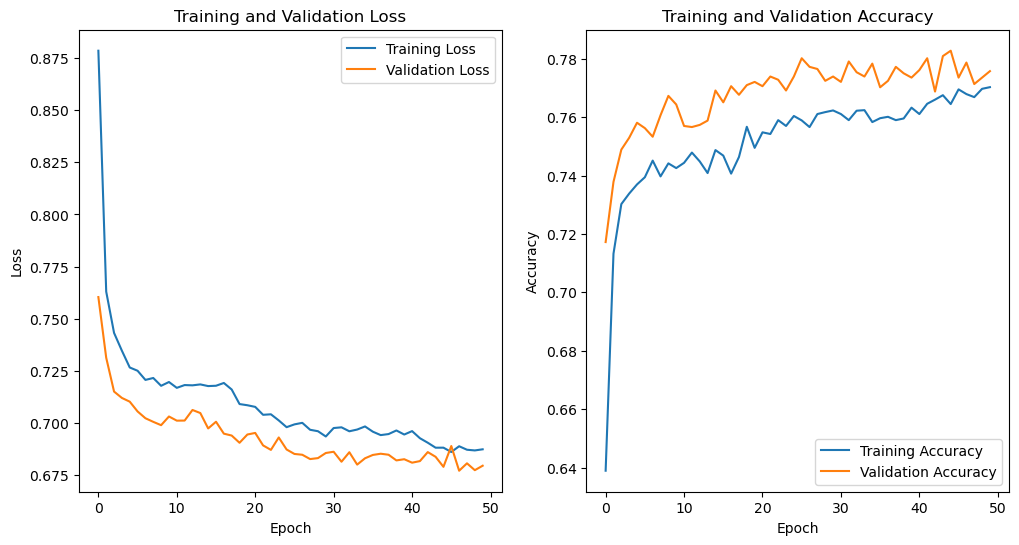

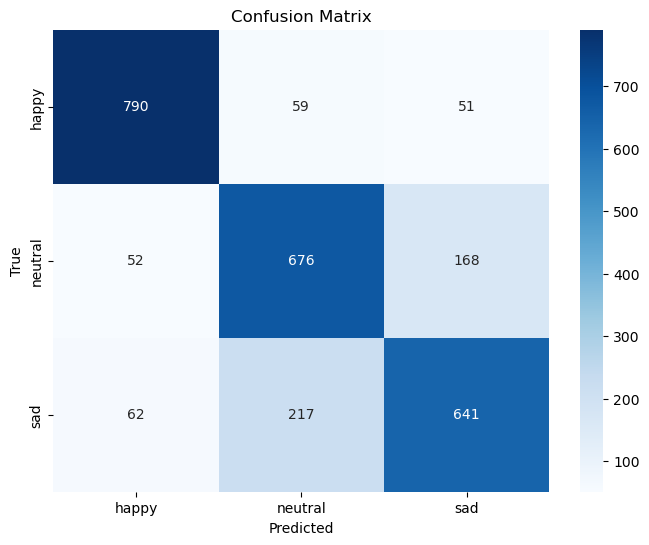

              precision    recall  f1-score   support

       happy       0.87      0.88      0.88       900
     neutral       0.71      0.75      0.73       896
         sad       0.75      0.70      0.72       920

    accuracy                           0.78      2716
   macro avg       0.78      0.78      0.78      2716
weighted avg       0.78      0.78      0.78      2716



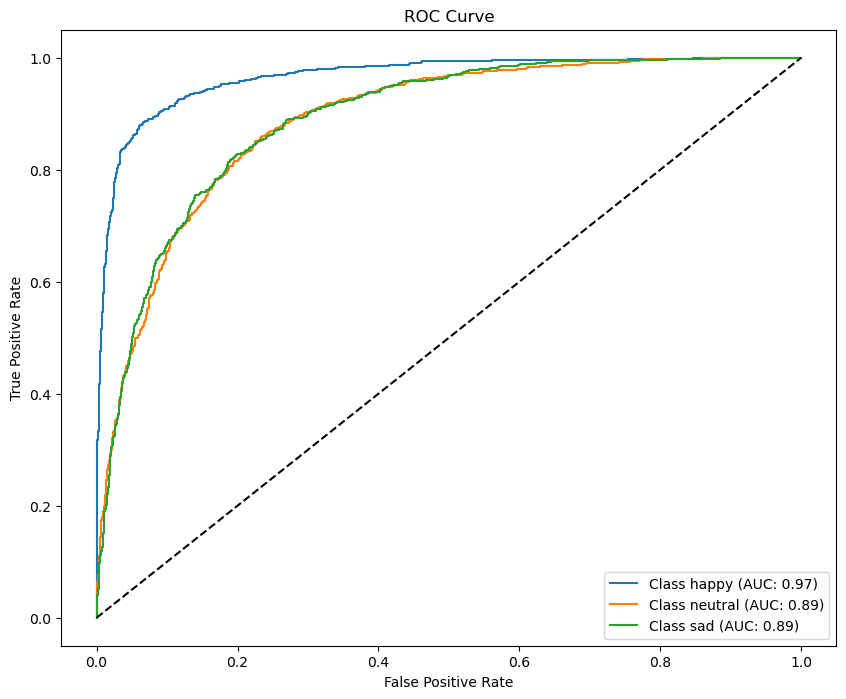

In [9]:
from transformers import SwinForImageClassification, AutoImageProcessor
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
from collections import Counter

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize feature extractor and Swin Transformer model
feature_extractor = AutoImageProcessor.from_pretrained('microsoft/swin-base-patch4-window7-224')
num_classes = 3  # Update this based on your dataset
model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-base-patch4-window7-224',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

# Freeze base model layers (optional, can fine-tune entire model later)
for param in model.swin.parameters():
    param.requires_grad = False

# Define preprocessing with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

# Load datasets
train_dir = "c:/users/butech/Downloads/image_dataset_3labeled/train"
val_dir = "c:/users/butech/Downloads/image_dataset_3labeled/validation"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class names
class_names = train_dataset.classes

# Calculate class weights for CrossEntropyLoss
class_counts = Counter(train_dataset.targets)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], device=device)

# Define loss with label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=0.1)

# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# Checkpoint path
checkpoint_path = "c:/users/butech/Downloads/swin_best_model.pth"

# Fine-tune the model
def fine_tune_model(model, train_loader, val_loader, epochs):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct_train, total_train = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Accuracy calculation
            preds = torch.argmax(outputs, axis=1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Validation phase
        model.eval()
        val_loss = 0
        correct_val, total_val = 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, axis=1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)
        scheduler.step()

        # Save checkpoint if this is the best model so far
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved at epoch {epoch + 1} with validation loss: {best_val_loss:.4f}")

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1] * 100:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1] * 100:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred

# Train the fine-tuned model for 50 epochs
epochs = 50
train_losses, val_losses, train_accuracies, val_accuracies, y_true, y_pred = fine_tune_model(model, train_loader, val_loader, epochs)

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Load the best model
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# ROC Curve
y_true_onehot = np.eye(len(class_names))[y_true]  # One-hot encode true labels
y_pred_probs = []

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        outputs = torch.softmax(model(images).logits, dim=1)
        y_pred_probs.append(outputs.cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs, axis=0)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC: {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
